# Pre-training a Masked Autoencoder with Keras

In [1]:
!pip install -U tensorflow-addons
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

import os
import shutil
from sklearn.model_selection import train_test_split


# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

2025-03-11 14:34:07.391621: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 14:34:07.406955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741714447.423085  165859 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741714447.426995  165859 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 14:34:07.443315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Hyperparameters for pretraining

Please feel free to change the hyperparameters and check your results. The best way to
get an intuition about the architecture is to experiment with it. Our hyperparameters are
heavily inspired by the design guidelines laid out by the authors in
[the original paper](https://arxiv.org/abs/2111.06377).

In [4]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 50

# AUGMENTATION
IMAGE_SIZE = 128  # We will resize input images to this size.
CHANNELS = 1
PATCH_SIZE = 16  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.50 # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 16
DEC_PROJECTION_DIM = 8
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

## Load and prepare the Cow Images Dataset

In [6]:
# Original directory containing all images
original_data_dir = 'png_512'

# Directory where you want to store training, validation, and test images
base_dir = 'data'

# Create directories for training, validation, and test sets
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# List of all image files in the original directory
all_files = [filename for filename in os.listdir(original_data_dir) if filename.endswith('.png')]
# Split the files into training, validation, and test sets
train_files, test_files = train_test_split(all_files, test_size=0.1, random_state=42)
train_files, validation_files = train_test_split(train_files, test_size=0.11, random_state=42)

# Function to copy files from a list to a destination directory
def copy_files(file_list, src_dir, dst_dir):
    for filename in file_list:
        src = os.path.join(src_dir, filename)
        dst = os.path.join(dst_dir, filename)
        shutil.copy(src, dst)

# Copy the files to the appropriate directories (without augmentation)
copy_files(train_files, original_data_dir, train_dir)
copy_files(validation_files, original_data_dir, validation_dir)
copy_files(test_files, original_data_dir, test_dir)

In [7]:

# Create a single dataset for all images (without classes).
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),              # Base directory
    labels='inferred',    # Infer labels from directory structure
    color_mode="grayscale",
    label_mode=None,     # Labels as integers
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Image size
    batch_size=BATCH_SIZE,         # Batch size
    shuffle=True,          # Shuffle data
    interpolation='bilinear'
)

# Create a single dataset for all images (without classes).
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),              # Base directory
    labels='inferred',    # Infer labels from directory structure
    color_mode="grayscale",
    label_mode=None,     # Labels as integers
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Image size
    batch_size=BATCH_SIZE,         # Batch size
    shuffle=True,          # Shuffle data
    interpolation='bilinear'
)

# Create a single dataset for all images (without classes).
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),              # Base directory
    labels='inferred',    # Infer labels from directory structure
    color_mode="grayscale",
    label_mode=None,     # Labels as integers
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Image size
    batch_size=BATCH_SIZE,         # Batch size
    shuffle=True,          # Shuffle data
    interpolation='bilinear'
)


Found 56617 files.
Found 6998 files.


W0000 00:00:1741715415.643943  165859 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 7069 files.


## Data augmentation

- Resizing
- Rescaling

In [8]:

def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
#             layers.RandomFlip("horizontal"),
#             layers.RandomRotation(factor=0.15),  # Rotação aleatória entre -30 e 30 graus (fator = 0.15 para 15 graus)
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0),
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model


## A layer for extracting patches from images

This layer takes images as input and divides them into patches. The layer also includes
two utility method:

- `show_patched_image` -- Takes a batch of images and its corresponding patches to plot a
random pair of image and patches.
- `reconstruct_from_patch` -- Takes a single instance of patches and stitches them
together into the original image.

In [9]:

class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE,
                 channels = CHANNELS, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.channels = channels

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * channels))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, self.channels))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, self.channels))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed


Let's visualize the image patches.

Index selected: 14.


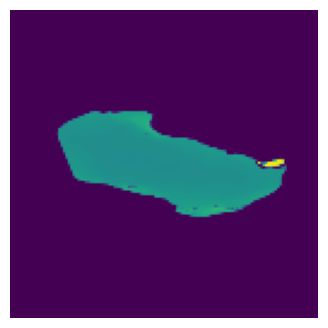

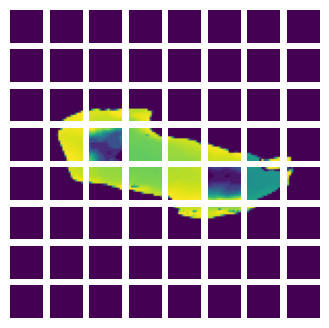

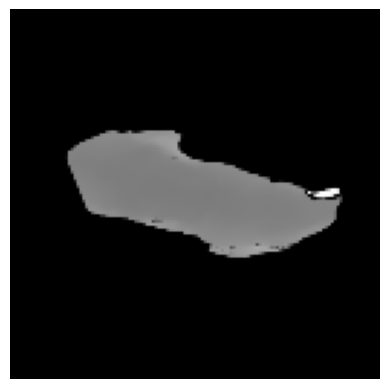

In [10]:
# Get a batch of images.
image_batch = next(iter(train_dataset))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches(channels = 1)

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image, cmap = 'gray')
plt.axis("off")
plt.show()

## Patch encoding with masking

Quoting the paper

> Following ViT, we divide an image into regular non-overlapping patches. Then we sample
a subset of patches and mask (i.e., remove) the remaining ones. Our sampling strategy is
straightforward: we sample random patches without replacement, following a uniform
distribution. We simply refer to this as “random sampling”.

This layer includes masking and encoding the patches.

The utility methods of the layer are:

- `get_random_indices` -- Provides the mask and unmask indices.
- `get_`
- `generate_masked_image` -- Takes patches and unmask indices, results in a random masked
image. This is an essential utility method for our training monitor callback (defined
later).

In [11]:

class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        channels = CHANNELS,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * channels]), trainable=True
        )
        

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        self.rand_indices = tf.argsort(
            tf.random.uniform(shape=(1, self.num_patches)), axis=-1
        )
        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices
    
    def get_indices(self, batch_size):
        
        rand_indices = tf.tile(self.rand_indices, [128, 1])

        mask_indices = rand_indices[:, :self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask:]

        return mask_indices, unmask_indices


    def get_ordered_indices(self, batch_size):
        # Create sequential indices.
        sequential_indices = tf.range(self.num_patches, dtype=tf.int32)

        # Separate even and odd indices.
        even_indices = sequential_indices[::2]
        odd_indices = sequential_indices[1::2]

        # Interleave even and odd indices.
        ordered_indices = tf.concat([even_indices, odd_indices], axis=0)

        # Repeat indices to match the batch size.
        ordered_indices = tf.tile(ordered_indices[tf.newaxis, :], [batch_size, 1])

        # Split indices into mask_indices and unmask_indices.
        mask_indices = ordered_indices[:, :self.num_mask]
        unmask_indices = ordered_indices[:, self.num_mask:]

        return mask_indices, unmask_indices

    def get_sorted_indices(self, batch_size):
        # Create sequential indices.
        sequential_indices = tf.range(self.num_patches, dtype=tf.int32)

        # Calculate the midpoint.
        midpoint = self.num_patches // 2

        # Calculate the distance of each index from the midpoint.
        distances = tf.abs(sequential_indices - midpoint)

        # Sort indices based on distances in descending order.
        sorted_indices = tf.argsort(-distances)

        # Repeat indices to match the batch size.
        sorted_indices = tf.tile(sorted_indices[tf.newaxis, :], [batch_size, 1])

        # Split indices into mask_indices and unmask_indices.
        mask_indices = sorted_indices[:, :self.num_mask]
        unmask_indices = sorted_indices[:, self.num_mask:]

        return mask_indices, unmask_indices

    
    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx


In [12]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

Let's see the masking process in action on a sample image.

(128, 64)


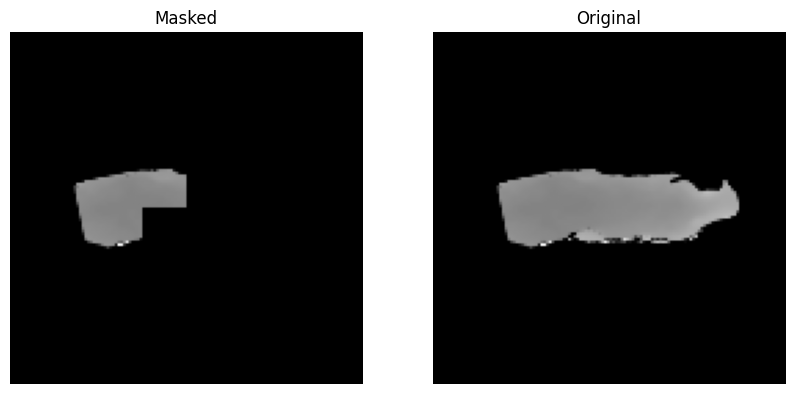

In [13]:


# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img), cmap = 'gray')
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img), cmap = 'gray')
plt.axis("off")
plt.title("Original")
plt.show()

## MLP

This serves as the fully connected feed forward network of the transformer architecture.

In [14]:

def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## MAE encoder

The MAE encoder is ViT. The only point to note here is that the encoder outputs a layer
normalized output.

In [15]:

def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")


## MAE decoder

The authors point out that they use an **asymmetric** autoencoder model. They use a
lightweight decoder that takes "<10% computation per token vs. the encoder". We are not
specific with the "<10% computation" in our implementation but have used a smaller
decoder (both in terms of depth and projection dimensions).

In [16]:

def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE,
    channels = CHANNELS
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * channels, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, channels))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


## MAE trainer

This is the trainer module. We wrap the encoder and decoder inside of a `tf.keras.Model`
subclass. This allows us to customize what happens in the `model.fit()` loop.

In [17]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}


## Model initialization

In [18]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

## Training callbacks

### Visualization callback

In [19]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_dataset))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image, cmap = 'gray')
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image, cmap = 'gray')
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image, cmap = 'gray')
            ax[2].set_title(f"Reconstructed: {epoch:03d}")

            plt.show()
            plt.close()


### Learning rate scheduler

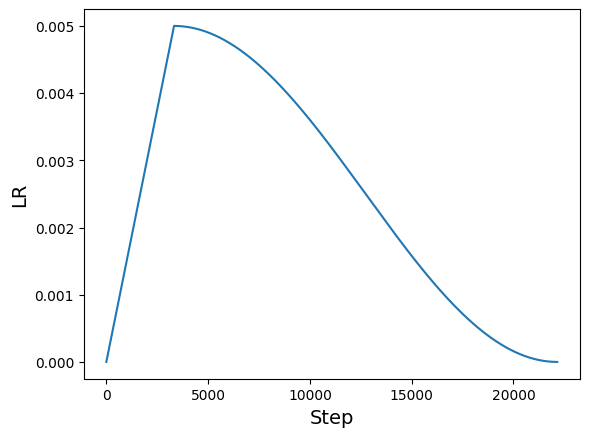

In [20]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(train_dataset)) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

## Model compilation and training

In [21]:
optimizer = tf.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

#Compile and pretrain the model.
mae_model.compile( optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

Epoch 1/50
(None, 64)


/home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:665: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:640: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


(None, 64)


2025-03-11 14:53:27.122913: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - mae: 0.2120 - loss: 0.2591(None, 64)
(128, 64)

Idx chosen: 71


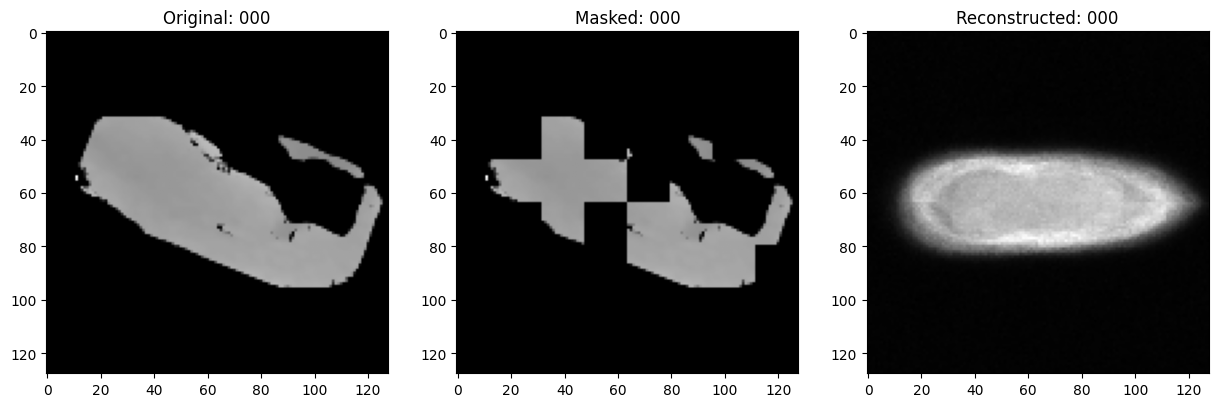

443/443 ━━━━━━━━━━━━━━━━━━━━ 54s 91ms/step - mae: 0.2116 - loss: 0.2588 - val_loss: 0.0908
Epoch 2/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - mae: 0.0394 - loss: 0.0875 - val_loss: 0.0871
Epoch 3/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - mae: 0.0321 - loss: 0.0846 - val_loss: 0.0829
Epoch 4/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - mae: 0.0279 - loss: 0.0830 - val_loss: 0.0793
Epoch 5/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - mae: 0.0265 - loss: 0.0824 - val_loss: 0.0862
Epoch 6/50
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - mae: 0.0257 - loss: 0.0824(128, 64)

Idx chosen: 60


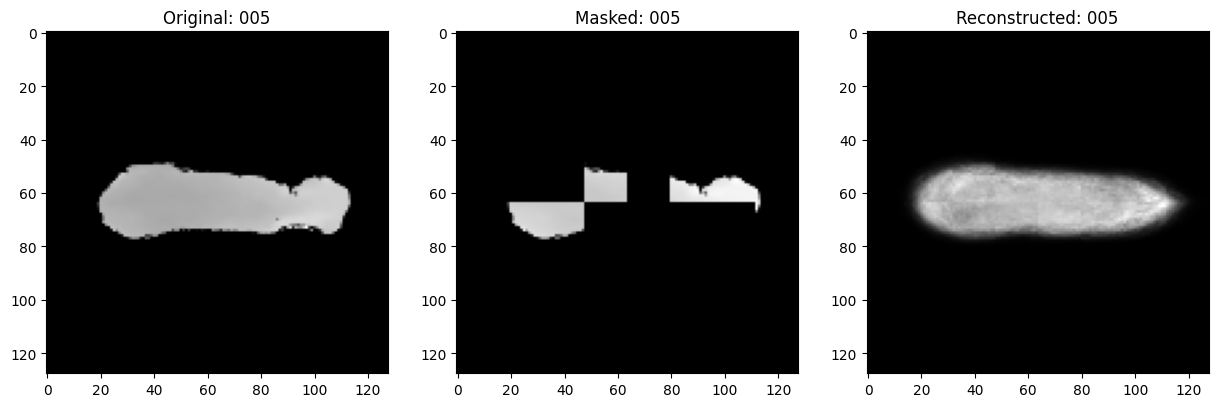

443/443 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - mae: 0.0257 - loss: 0.0824 - val_loss: 0.0822
Epoch 7/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - mae: 0.0253 - loss: 0.0824 - val_loss: 0.0815
Epoch 8/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - mae: 0.0251 - loss: 0.0826 - val_loss: 0.0802
Epoch 9/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - mae: 0.0245 - loss: 0.0825 - val_loss: 0.0847
Epoch 10/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - mae: 0.0239 - loss: 0.0822 - val_loss: 0.0824
Epoch 11/50
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - mae: 0.0235 - loss: 0.0823(128, 64)

Idx chosen: 20


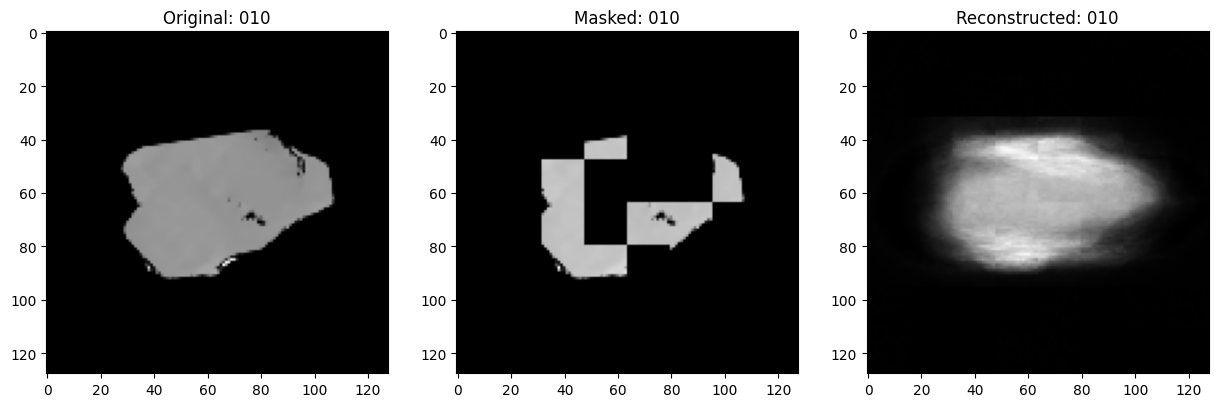

443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - mae: 0.0235 - loss: 0.0823 - val_loss: 0.0815
Epoch 12/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0232 - loss: 0.0820 - val_loss: 0.0850
Epoch 13/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0229 - loss: 0.0819 - val_loss: 0.0802
Epoch 14/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0227 - loss: 0.0818 - val_loss: 0.0799
Epoch 15/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0226 - loss: 0.0818 - val_loss: 0.0812
Epoch 16/50
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - mae: 0.0223 - loss: 0.0818(128, 64)

Idx chosen: 102


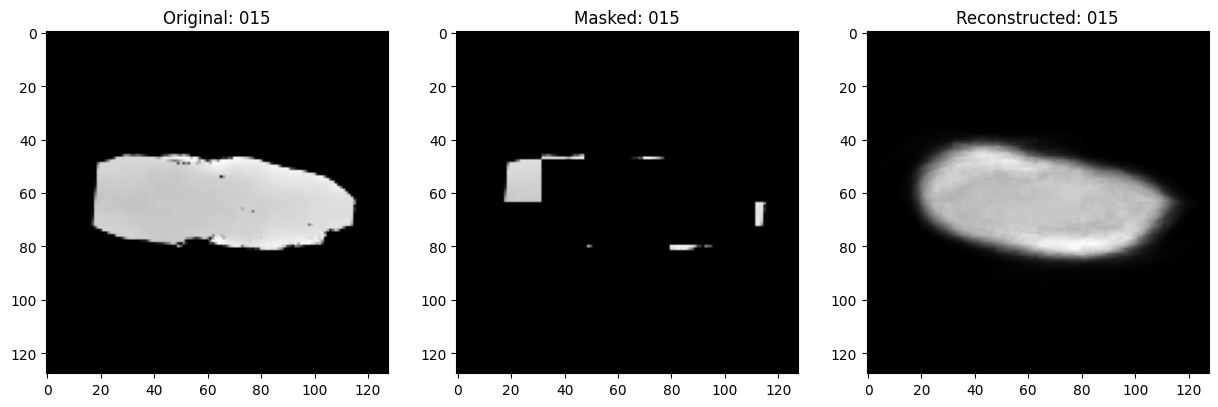

443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - mae: 0.0223 - loss: 0.0818 - val_loss: 0.0789
Epoch 17/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0223 - loss: 0.0817 - val_loss: 0.0793
Epoch 18/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0221 - loss: 0.0817 - val_loss: 0.0797
Epoch 19/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - mae: 0.0219 - loss: 0.0818 - val_loss: 0.0820
Epoch 20/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - mae: 0.0216 - loss: 0.0817 - val_loss: 0.0837
Epoch 21/50
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - mae: 0.0213 - loss: 0.0813(128, 64)

Idx chosen: 121


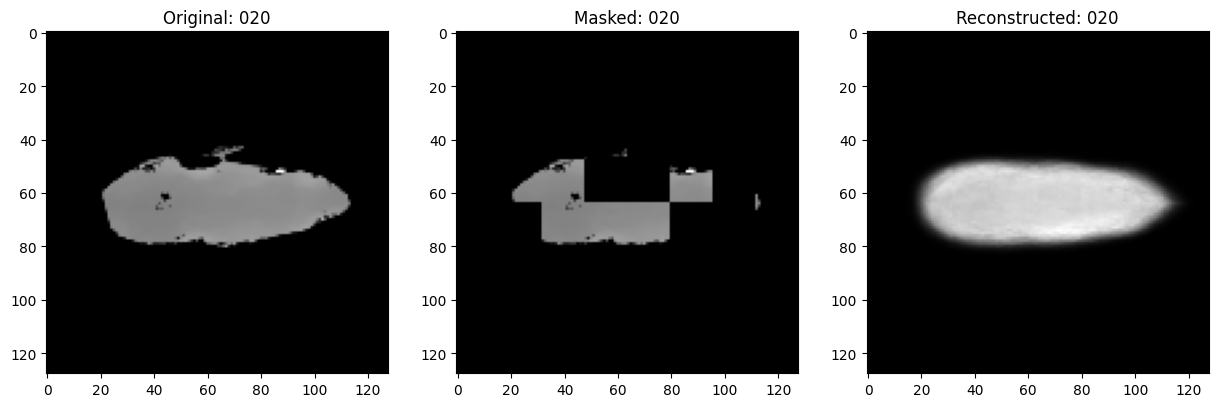

443/443 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - mae: 0.0213 - loss: 0.0813 - val_loss: 0.0794
Epoch 22/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - mae: 0.0214 - loss: 0.0812 - val_loss: 0.0825
Epoch 23/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0211 - loss: 0.0813 - val_loss: 0.0804
Epoch 24/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - mae: 0.0210 - loss: 0.0812 - val_loss: 0.0810
Epoch 25/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0209 - loss: 0.0814 - val_loss: 0.0810
Epoch 26/50
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - mae: 0.0207 - loss: 0.0811(128, 64)

Idx chosen: 82


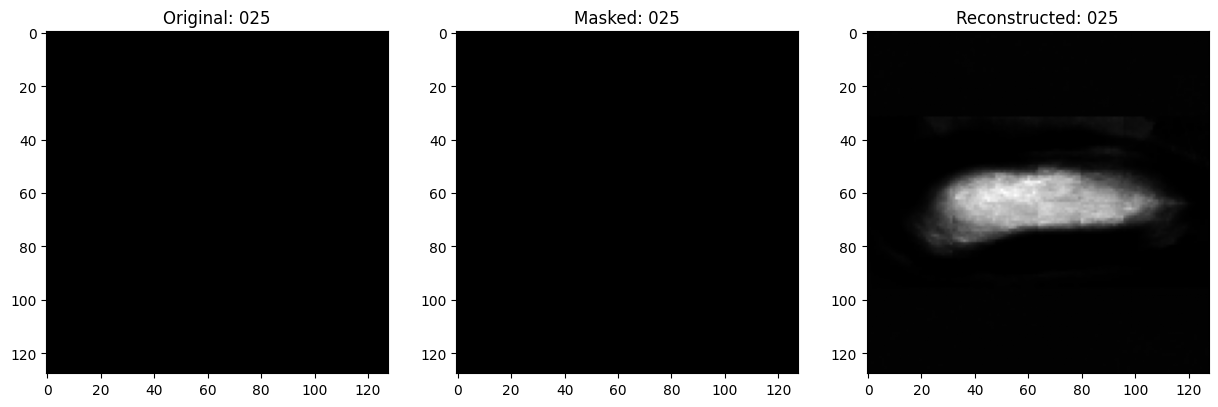

443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - mae: 0.0207 - loss: 0.0811 - val_loss: 0.0816
Epoch 27/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - mae: 0.0206 - loss: 0.0810 - val_loss: 0.0816
Epoch 28/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - mae: 0.0204 - loss: 0.0811 - val_loss: 0.0841
Epoch 29/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - mae: 0.0203 - loss: 0.0810 - val_loss: 0.0812
Epoch 30/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - mae: 0.0201 - loss: 0.0808 - val_loss: 0.0820
Epoch 31/50
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - mae: 0.0200 - loss: 0.0809(128, 64)

Idx chosen: 86


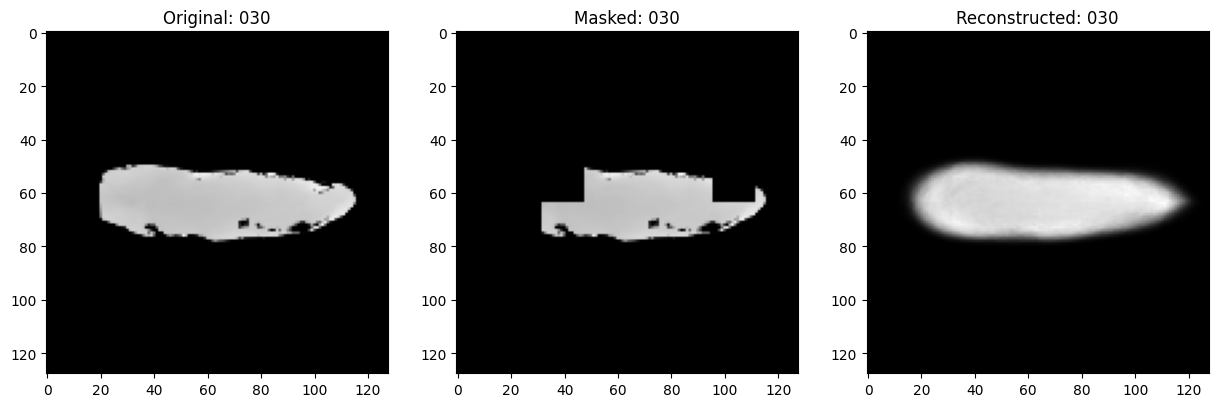

443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - mae: 0.0200 - loss: 0.0809 - val_loss: 0.0825
Epoch 32/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - mae: 0.0199 - loss: 0.0809 - val_loss: 0.0818
Epoch 33/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - mae: 0.0198 - loss: 0.0810 - val_loss: 0.0784
Epoch 34/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0197 - loss: 0.0809 - val_loss: 0.0810
Epoch 35/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0195 - loss: 0.0807 - val_loss: 0.0822
Epoch 36/50
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - mae: 0.0193 - loss: 0.0807(128, 64)

Idx chosen: 74


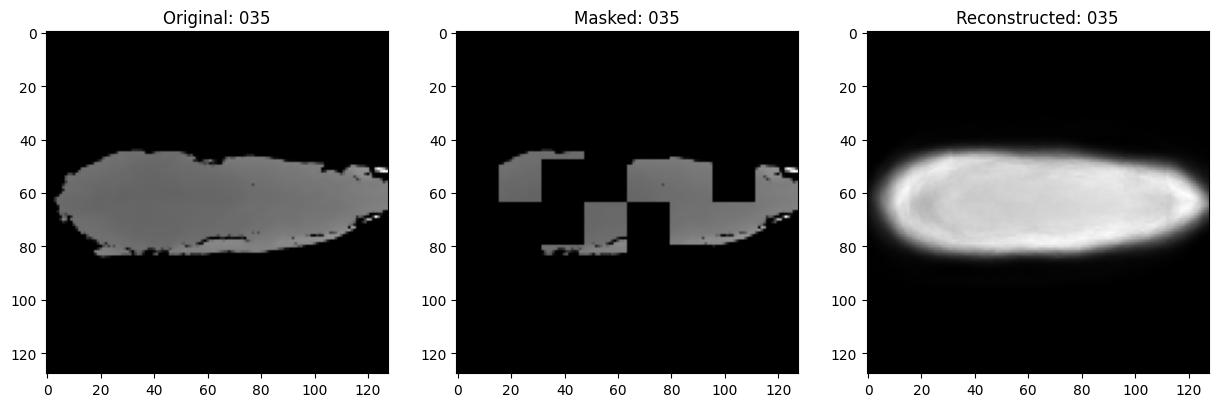

443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - mae: 0.0193 - loss: 0.0807 - val_loss: 0.0802
Epoch 37/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0193 - loss: 0.0808 - val_loss: 0.0808
Epoch 38/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - mae: 0.0192 - loss: 0.0807 - val_loss: 0.0816
Epoch 39/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - mae: 0.0191 - loss: 0.0809 - val_loss: 0.0809
Epoch 40/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - mae: 0.0190 - loss: 0.0806 - val_loss: 0.0805
Epoch 41/50
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - mae: 0.0189 - loss: 0.0804(128, 64)

Idx chosen: 74


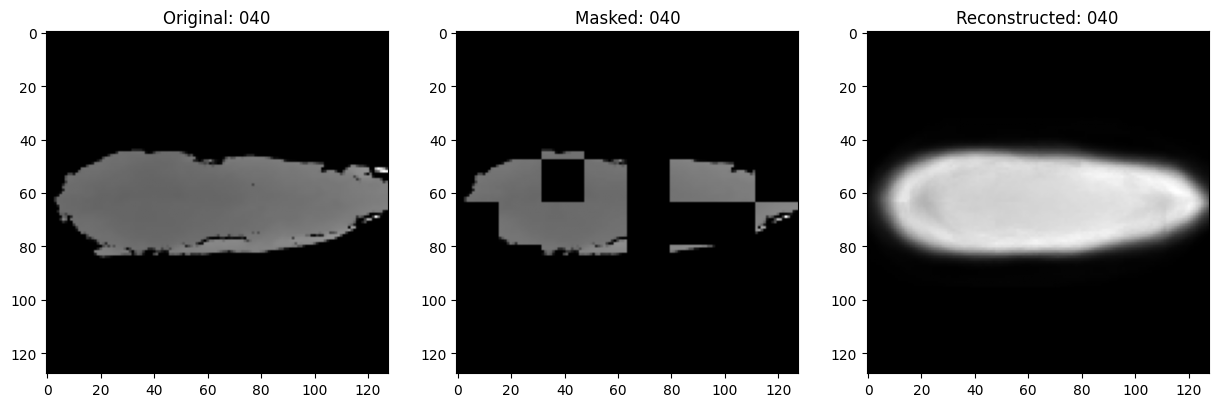

443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - mae: 0.0189 - loss: 0.0804 - val_loss: 0.0804
Epoch 42/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - mae: 0.0188 - loss: 0.0805 - val_loss: 0.0800
Epoch 43/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - mae: 0.0187 - loss: 0.0804 - val_loss: 0.0795
Epoch 44/50
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - mae: 0.0186 - loss: 0.0804

In [ ]:

history = mae_model.fit(
    train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_dataset)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

## Saving the pre trained model

In [ ]:
import tensorflow as tf

check_point = "dim16_mp50"


#####################
# PATCH_ENCODER
#####################

# Salve as trainable variables do encoder em uma lista
pe_trainable_variables = mae_model.patch_encoder.trainable_variables

# Escolha um diretório para salvar os checkpoints do encoder
pe_checkpoint_directory = check_point+ '/pe/'

# Crie um objeto tf.train.Checkpoint para salvar as variáveis do encoder
pe_checkpoint = tf.train.Checkpoint(variables=pe_trainable_variables)

# Salve os trainable variables do encoder
pe_checkpoint.save(file_prefix=pe_checkpoint_directory)


#####################
# ENCODER
#####################

# Salve as trainable variables do encoder em uma lista
encoder_trainable_variables = mae_model.encoder.trainable_variables

# Escolha um diretório para salvar os checkpoints do encoder
encoder_checkpoint_directory = check_point + '/encoder/'

# Crie um objeto tf.train.Checkpoint para salvar as variáveis do encoder
encoder_checkpoint = tf.train.Checkpoint(variables=encoder_trainable_variables)

# Salve os trainable variables do encoder
encoder_checkpoint.save(file_prefix=encoder_checkpoint_directory)

#####################
# DECODER
#####################


# Salve as trainable variables do decoder em uma lista
decoder_trainable_variables = mae_model.decoder.trainable_variables

# Escolha um diretório para salvar os checkpoints do decoder
decoder_checkpoint_directory = check_point +'/decoder/'

# Crie um objeto tf.train.Checkpoint para salvar as variáveis do decoder
decoder_checkpoint = tf.train.Checkpoint(variables=decoder_trainable_variables)

# Salve os trainable variables do decoder
decoder_checkpoint.save(file_prefix=decoder_checkpoint_directory) 



In [ ]:
# Measure its performance.
loss, mae = mae_model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"MAE: {mae}")

In [ ]:
import json

# Save the history to a file
with open(check_point + "history.json", 'w') as json_file:
    json.dump(history.history, json_file)